### NOTE: The code is not written to achieve good accuracy which is the intention of any classification model. Here the steps were shown which we usually follow in a traditional classification problem as we are using BERT embeddings which also sometime handle few stop words so we haven't do text preprocessing (which bert_preprocessing layer can also do) which is again a crucial step to get good accuracy.

In [1]:
%%capture

# installing transformers library, well known for NLP
!pip install transformers
!pip install -q -U "tensorflow-text==2.9.0"

In [2]:
import os
import re
import json
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split


In [3]:
import tensorflow as tf

from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from transformers import BertTokenizer, TFBertModel

#### Data Loading

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# loading data files as lines and converting them as 
# json object for parsing, then converting into dataframe.
def data_fetcher(data_file):
    raw_data = []
    with open(data_file) as file:
            for line in file:
                raw_data.append(json.loads(line))

    raw_data_df = pd.DataFrame(raw_data)

    return raw_data_df

In [6]:
train_df = data_fetcher('/content/drive/MyDrive/vfirst/train.jsonl')
test_df = data_fetcher('/content/drive/MyDrive/vfirst/test.jsonl')
val_df = data_fetcher('/content/drive/MyDrive/vfirst/dev.jsonl')

In [7]:
len(train_df), len(test_df), len(val_df)

(8544, 2210, 1101)

In [8]:
# combining data for auto tain_test split of X & Y later on instead of explicit doing.

combine_df = pd.concat([train_df, test_df, val_df], axis=0)

#### Performing basic EDA

In [9]:
combine_df.sample(5)

,text,label,label_text
8153,an occasionally interesting but mostly repetit...,1,negative
5570,if we sometimes need comforting fantasies abou...,3,positive
6599,there 's so much to look at in metropolis you ...,4,very positive
494,"the movie is as far as you can get from racy ,...",0,very negative
120,there 's something fundamental missing from th...,1,negative


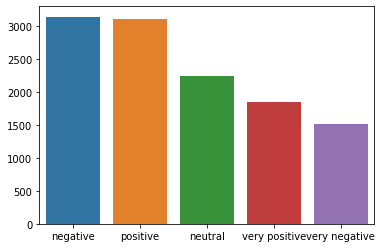

In [10]:
# class label ratio

x = list(combine_df['label_text'].value_counts().keys())
y = list(combine_df['label_text'].value_counts().values)
sns.barplot(x=x, y=y)

In [11]:
for i, row in enumerate(combine_df.iterrows()):
    row = row[1]
    print(f"{i+1}:",row['text'])
    print()
    if i == 5:
        break

1: a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films

2: apparently reassembled from the cutting-room floor of any given daytime soap .

3: they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes .

4: the entire movie is filled with deja vu moments .

5: this is a visually stunning rumination on love , memory , history and the war between art and commerce .

6: um , no. .



In [ ]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [43]:
# BERT tokenizer example (to demonstrate what BERT do behind the scene)

sample_text = "Hello Shyam, how are you?"

# generating tokens
tokens = tokenizer.tokenize(sample_text)
print("tokens:",tokens,'\n')

ids = tokenizer.convert_tokens_to_ids(tokens)
print("convert_tokens_to_ids:",ids,'\n')


ids_encode = tokenizer.encode(sample_text,add_special_tokens = True,
                                   max_length =30,pad_to_max_length = True,
                                   return_attention_mask = True)
print("encode:",ids_encode,'\n')



ids_encode_plus = tokenizer.encode_plus(sample_text,add_special_tokens = True,max_length =30,pad_to_max_length = True,
return_attention_mask = True)
print("encode_plus:",ids_encode_plus,'\n')

print("convert_ids_to_tokens:",tokenizer.convert_ids_to_tokens(ids),'\n')

print("decode:",tokenizer.decode(ids_encode_plus['input_ids']),'\n')

print("convert_ids_to_tokens(101):",tokenizer.convert_ids_to_tokens(101))

tokens: ['hello', 'shy', '##am', ',', 'how', 'are', 'you', '?'] 

convert_tokens_to_ids: [7592, 11004, 3286, 1010, 2129, 2024, 2017, 1029] 

encode: [101, 7592, 11004, 3286, 1010, 2129, 2024, 2017, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

encode_plus: {'input_ids': [101, 7592, 11004, 3286, 1010, 2129, 2024, 2017, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]} 

convert_ids_to_tokens: ['hello', 'shy', '##am', ',', 'how', 'are', 'you', '?'] 

decode: [CLS] hello shyam, how are you? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

convert_ids_to_tokens(101): [CLS]


#### Modeling

In [44]:
# identifying max length of text to set the padding till the max length.

max_len_text = 0
for txt in test_df['text'].values:
  # print(len(txt))
  if len(txt) > max_len_text:
    max_len_text = len(txt)
  else:
    pass
print(max_len_text)

256


In [12]:
# hyperparameters
max_length = 256
batch_size = 16

#### Train-test split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(train_df['text'], train_df['label'], test_size=0.2)

In [16]:
# x_train = train_df['text']
# y_train = train_df['label']

# x_test = test_df['text']
# y_test = test_df['label']

In [17]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [18]:
train_encoded = bert_encode(x_train)
test_encoded = bert_encode(x_test)


train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, y_train))
    .shuffle(100)
    .batch(batch_size)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_encoded, y_test))
    .shuffle(100)
    .batch(batch_size)
)

In [26]:
def bert_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]    
    x = tf.keras.layers.LSTM(100, dropout=0.3, recurrent_dropout=0.3)(last_hidden_states)


    net = tf.keras.layers.Dense(64,activation='relu')(x)
    #net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(16,activation='relu')(net)
    net = tf.keras.layers.Dense(5, activation=None, name='classifier')(net)


    model = tf.keras.Model(inputs=input_word_ids, outputs=net)
    
    return model

In [27]:
model = bert_model()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 283)]             0         
                                                                 
 tf_bert_model_2 (TFBertMode  TFBaseModelOutputWithPoo  109482240
 l)                          lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             283, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

In [28]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=3,
    validation_data=test_dataset)


Epoch 1/3


428/428 [==============================] - 1002s 2s/step - loss: -5.1356 - accuracy: 0.2279 - val_loss: -6.7441 - val_accuracy: 0.2774
Epoch 2/3
428/428 [==============================] - 896s 2s/step - loss: -6.5111 - accuracy: 0.2380 - val_loss: -6.7441 - val_accuracy: 0.2774
Epoch 3/3
428/428 [==============================] - 900s 2s/step - loss: -6.5097 - accuracy: 0.2323 - val_loss: -6.7441 - val_accuracy: 0.2774


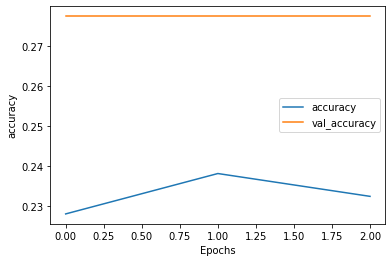

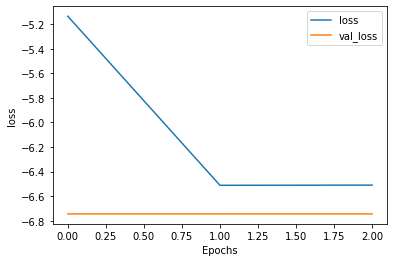

In [29]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [30]:
predicted = model.predict(test_dataset, batch_size=batch_size)


107/107 [==============================] - 49s 422ms/step
